In [1]:
from relaxations import *
from parameters import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chspy import CubicHermiteSpline
from scipy.interpolate import CubicSpline

In [2]:
# read experimental data
df_reversed = pd.read_csv("./data/dollar_insert.csv",header=None)
df = df_reversed.iloc[::-1]
df = df.reset_index(drop=True)

# get indicies for comparison
t0 = 300.00
tf = 1000.00
T = np.arange(0.0,tf,0.01)
t_before_data = (1110-df[0][0])*60
duration_data = (df.iloc[-1][0]-df[0][0])*60
t_end_data = df.iloc[-1][0]
t_before_sim = t0-t_before_data
T_insert = [t for t in T if (t > (t_before_sim)) and (t < (t_before_sim)+(duration_data))]
i_insert = [t[0] for t in enumerate(T) if (t[1] > (t_before_sim)) and (t[1] < (t_before_sim)+(duration_data))]

adj = (df[0][0])*60-T_insert[0]
df[0] = [(t*60)-adj for t in df[0]]

# Set up interpolation
# Assuming df[0] is time and df[1] is the data you want to interpolate
spline = CubicSpline(df[0], df[1])  # Multiplying df[0] by 60 if it's in minutes

# Use the spline to interpolate at the desired times
interpolated_values = spline(T[i_insert[0]:i_insert[-1]+1])

def sumSq_initial(params):
    try:
        # run
        sol_jit = relax_feedback_insertion_beta(params)
        
        # calculate error
        simulation_output = [s[6]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)]
        error = sum((simulation_output - interpolated_values)**2)  # Sum of squared errors
        return error
    except:
        return float('inf')

def sumSq_delays(params):
    #try:
    # run
    sol_jit = relax_delays(params) 
    
    # calculate error
    simulation_output = [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)]
    error = sum((simulation_output - interpolated_values)**2)  # Sum of squared errors
    return error
    #except:
    #    return float('inf')
    


In [3]:

from scipy.optimize import minimize

def estimate_feedback():
    # set bounds
    a_f0 = -9.8e-5
    a_f_bounds = (-20e-5, 20e-5)

    a_b0 = -1.1e-5
    a_b_bounds = (-5e-5, 5e-5)

    a_c0 = -5.88e-5
    a_c_bounds = (-20e-5, 20e-5)

    ins0 = 4e-3
    ins_bounds = (1e-3, 20e-3)

    b0 = beta_t
    b_bounds = (1e-3,10e-3)
    
    initial_guess = [a_f0,a_b0,a_c0,ins0,b0]
    bounds = [a_f_bounds,a_b_bounds,a_c_bounds,ins_bounds,b_bounds]

    # minimize
    result = minimize(sumSq_initial, initial_guess, bounds=bounds)

    return result
    
def estimate_delays():
    # set bounds
    initial_hx_c_f = 10.0
    hx_c_f_bounds = (5.0, 60.0)
    
    initial_hx_c_c = 10.0
    hx_c_c_bounds = (5.0, 60.0)

    initial_c_hx_f = 10.0
    c_hx_f_bounds = (5.0, 60.0)

    initial_h_loop_f = 1.0
    h_loop_f_bounds = (0.0, 5.0)

    initial_h_btw_f = 0.1
    h_btw_f_bounds = (0.0, 3.0)

    initial_c_hx_c = 10.0
    c_hx_c_bounds = (5.0, 60.0)

    initial_h_loop_c = 1.0
    h_loop_c_bounds = (0.0, 5.0)

    initial_h_btw_c = 0.1
    h_btw_c_bounds = (0.0, 3.0)

    initial_guess = [initial_hx_c_f,initial_hx_c_c,initial_c_hx_f,initial_h_loop_f,
                     initial_h_btw_f,initial_c_hx_c,initial_h_loop_c,initial_h_btw_c]


    bounds = [hx_c_f_bounds,hx_c_c_bounds,c_hx_f_bounds,h_loop_f_bounds,h_btw_f_bounds,
              c_hx_c_bounds,h_loop_c_bounds,h_btw_c_bounds]

    # minimize
    result = minimize(sumSq_delays, initial_guess, bounds=bounds)

    return result

In [4]:
result = estimate_feedback()

Generating, compiling, and loading C code.
Using default integration parameters.


/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.
  warn("You did not explicitly handle initial discontinuities. Proceed only if you know what you are doing. This is only fine if you somehow chose your initial past such that the derivative of the last anchor complies with the DDE. In this case, you can set the attribute `initial_discontinuities_handled` to `True` to suppress this warning. See https://jitcdde.rtfd.io/#discontinuities for details.")
/home/luke/git/envs/thesis_env/lib/python3.11/site-packages/jitcdde/_jitcdde.py:795: UserWarning: You did no

Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and loading C code.
Using default integration parameters.
Generating, compiling, and l

In [10]:
result.x

array([2.00000000e-04, 5.00000000e-05, 2.00000000e-04, 1.02415310e-03,
       9.99999821e-03])

In [6]:
# # debug 
# initial_hx_c_f = 3.0
# initial_hx_c_c = 3.0
# initial_c_hx_f = 3.0
# initial_h_loop_f = 1.0
# initial_h_btw_f = 0.0
# initial_c_hx_c = 3.0
# initial_h_loop_c = 1.0
# initial_h_btw_c = 0.0
# initial_guess = [initial_hx_c_f,initial_hx_c_c,initial_c_hx_f,initial_h_loop_f,
#                     initial_h_btw_f,initial_c_hx_c,initial_h_loop_c,initial_h_btw_c]

# # run
# sol_jit = relax_delays(initial_guess) 

# # calculate error
# simulation_output = [s[46]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)]
# error = sum((simulation_output - interpolated_values)**2)  # Sum of squared errors
# print(error)

# 30 sec delay: 48613.06075551406
# 3 second delay: 56541.19245646346

NameError: name 'c_m' is not defined

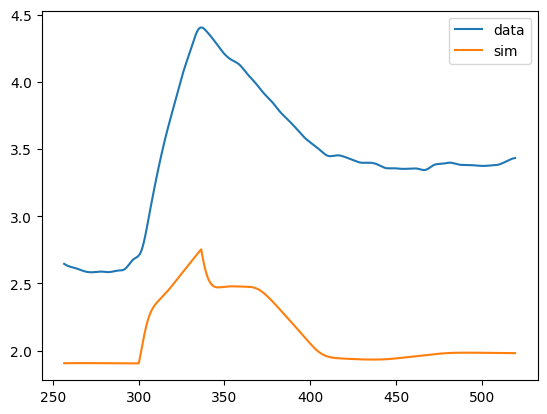

In [ ]:
# plt.plot(T_insert,interpolated_values,label="data")
# plt.plot(T_insert,simulation_output,label="sim")
# plt.legend()

Initial values & solve

In [11]:
# very close agreement, wide bounds


# res_initial = [-8.497785537606717e-05,1.98e-05,6.550691971743104e-05,0.0028672267097399427,0.0028672267097399427]
#res_delays = [1.00279579e+01, 1.00013936e+01, 6.00000000e+01, 1.49470027e-02,0.00000000e+00, 6.00000000e+01, 1.41107262e-01, 0.00000000e+00]
#res_delays = [20.00000009, 19.99999998, 20.00000011,  1.        ,  0.        ,
#       20.00000008,  1.00000005,  0.        ]
# res_ht = [0.05336143, 0.03110541, 0.0092151 , 0.00950064, 0.00380144,0.02186719, 0.02690063, 0.0214901 , 0.0121301 , 0.02106943,0.01217056]
sol_jit = relax_feedback_insertion_beta(result.x)

Generating, compiling, and loading C code.
Using default integration parameters.


(250.0, 500.0)

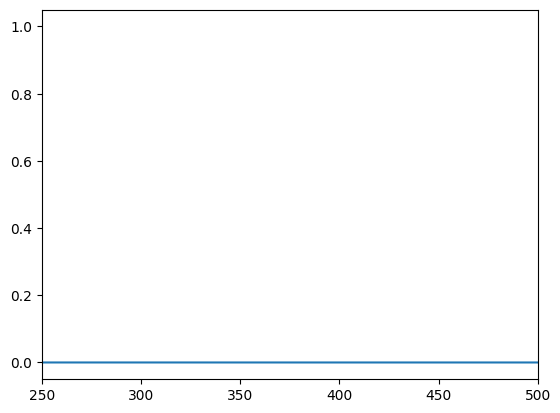

In [16]:

plt.plot(T,[s[6] for s in sol_jit])
plt.xlim([250,500])
# # read original data 
# # unpack data 
# filename = 'data/insert_out_999.99_2.2.txt' 
# sol_jit_orig = []

# # Open the file for reading
# with open(filename, 'r') as file:
#     # Iterate over each line in the file
#     for line in file:
#         # Split the line into components, convert each to float, and append to sol_jit
#         sol_jit_orig.append([float(value) for value in line.split()])

Text(0.5, 1.0, 'ORNL-1845 vs Simulation')

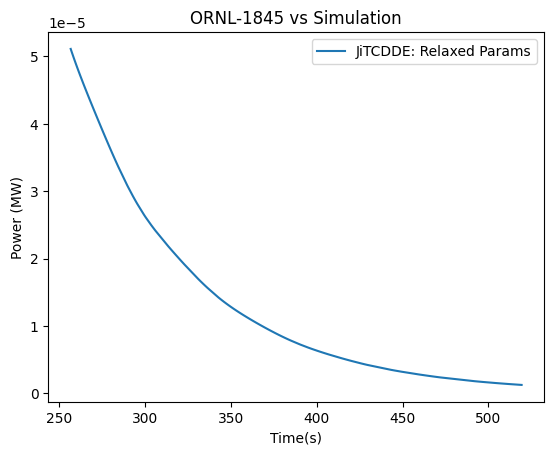

In [9]:

#plt.plot(T_insert, interpolated_values,label="ORNL-1845")
#plt.plot([s[0] for s in sol_jit_orig], [s[47]*P for s in sol_jit_orig],label="JitCDDE: Baseline")
plt.plot(T_insert, [s[6]*P for s in sol_jit][i_insert[0]:(i_insert[-1]+1)],label="JiTCDDE: Relaxed Params")
plt.legend()
plt.ylabel("Power (MW)")
plt.xlabel("Time(s)")
plt.title("ORNL-1845 vs Simulation")

In [ ]:
fig,axs = plt.subplots(3,3,figsize=(18,18))

t_0 = 0.0
t_f = 1000
T = np.arange(t_0,t_f,0.01)

p_error = 0.17

axs[0,0].set_xlim([t_0,t_f])
axs[0,0].plot(T,[s[0] for s in sol_jit],label="core f1") 
axs[0,0].plot(T,[s[1] for s in sol_jit],label="core f2") 
axs[0,0].plot(T,[s[2] for s in sol_jit],label="core t1")  
axs[0,0].plot(T,[s[3] for s in sol_jit],label="core c1")
axs[0,0].plot(T,[s[4] for s in sol_jit],label="core c2")
axs[0,0].plot(T,[s[5] for s in sol_jit],label="core m")
axs[0,0].legend()
axs[0,0].set_title("Core Node Temperatures (K)")
axs[0,0].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off


axs[0,1].set_xlim([t_0,t_f])
# axs[0,1].set_ylim([650,750])
axs[0,1].plot(T,[s[6] for s in sol_jit],label="hx_fh f1") 
axs[0,1].plot(T,[s[7] for s in sol_jit],label="hx_fh f2") 
axs[0,1].plot(T,[s[8] for s in sol_jit],label="hx_fh t1")  
axs[0,1].plot(T,[s[9] for s in sol_jit],label="hx_fh h1")
axs[0,1].plot(T,[s[10] for s in sol_jit],label="hx_fh h2")
axs[0,1].plot(T,[s[34] for s in sol_jit],label="hx_fh2 f1") 
axs[0,1].plot(T,[s[35] for s in sol_jit],label="hx_fh2 f2") 
axs[0,1].plot(T,[s[36] for s in sol_jit],label="hx_fh2 t1")  
axs[0,1].plot(T,[s[37] for s in sol_jit],label="hx_fh2 h1")
axs[0,1].plot(T,[s[38] for s in sol_jit],label="hx_fh2 h2")

axs[0,1].legend()
axs[0,1].set_title("HX Fuel->Helium Node Temperatures (K)")
#axs[0,1].tick_params(
#    axis='x',          # changes apply to the x-axis
#    which='both',      # both major and minor ticks are affected
#    bottom=False,      # ticks along the bottom edge are off
#    top=False,         # ticks along the top edge are off
#    labelbottom=False) # labels along the bottom edge are off

axs[0,2].set_xlim([t_0,t_f])
axs[0,2].plot(T,[s[16] for s in sol_jit],label="hx_hwf h1") 
axs[0,2].plot(T,[s[17] for s in sol_jit],label="hx_hwf h2") 
axs[0,2].plot(T,[s[18] for s in sol_jit],label="hx_hwf t1")  
axs[0,2].plot(T,[s[19] for s in sol_jit],label="hx_hwf w1")
axs[0,2].plot(T,[s[20] for s in sol_jit],label="hx_hwf w2")
axs[0,2].plot(T,[s[44] for s in sol_jit],label="hx_hwf2 h1") 
axs[0,2].plot(T,[s[45] for s in sol_jit],label="hx_hwf2 h2") 
axs[0,2].plot(T,[s[46] for s in sol_jit],label="hx_hwf2 t1")  
axs[0,2].plot(T,[s[47] for s in sol_jit],label="hx_hwf2 w1")
axs[0,2].plot(T,[s[48] for s in sol_jit],label="hx_hwf2 w2")
axs[0,2].legend()
axs[0,2].set_title("HX Helium->Water (Fuel Loop) Node Temperatures (K)")
axs[0,2].tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

axs[1,1].set_xlim([t_0,t_f])
axs[1,1].plot(T,[s[11] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[12] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[13] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[14] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[15] for s in sol_jit],label="hx_ch h2")
axs[1,1].plot(T,[s[39] for s in sol_jit],label="hx_ch f1") 
axs[1,1].plot(T,[s[40] for s in sol_jit],label="hx_ch f2") 
axs[1,1].plot(T,[s[41] for s in sol_jit],label="hx_ch t1")  
axs[1,1].plot(T,[s[42] for s in sol_jit],label="hx_ch h1")
axs[1,1].plot(T,[s[43] for s in sol_jit],label="hx_ch h2")
axs[1,1].legend()
axs[1,1].legend()
axs[1,1].set_title("HX Coolant->Helium Node Temperatures (K)")

# fuel temps
axs[1,2].set_xlim([t_0,t_f])
axs[1,2].plot(T,[s[21] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[22] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[23] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[24] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[25] for s in sol_jit],label="hx_hwc w2")
axs[1,2].plot(T,[s[49] for s in sol_jit],label="hx_hwc h1") 
axs[1,2].plot(T,[s[50] for s in sol_jit],label="hx_hwc h2") 
axs[1,2].plot(T,[s[51] for s in sol_jit],label="hx_hwc t1")  
axs[1,2].plot(T,[s[52] for s in sol_jit],label="hx_hwc w1")
axs[1,2].plot(T,[s[53] for s in sol_jit],label="hx_hwc w2")
axs[1,2].legend()
axs[1,2].set_title("HX Helium->Water (Coolant Loop) Node Temperatures (K)")

axs[1,0].plot(T,[s[46] for s in sol_jit],label="n") 
axs[1,0].plot(T,[(1+p_error)*s[46] for s in sol_jit],linestyle="--",label="+20%") 
axs[1,0].plot(T,[(1-p_error)*s[46] for s in sol_jit],linestyle="--",label="-20%") 
axs[1,0].set_xlabel("t (s)")
axs[1,0].set_title(r"$n$")
axs[1,0].set_ylabel(r"$\frac{n}{n_0}$")
axs[1,0].set_xlim([t_0,t_f])
axs[1,0].legend()

axs[2,0].plot(T,[s[53] for s in sol_jit],label="rho") 
axs[2,0].set_xlabel("t (s)")
axs[2,0].set_title(r"$\rho$")
axs[2,0].set_xlim([t_0,t_f])

axs[2,1].plot(T,[s[47] for s in sol_jit],label="C1") 
axs[2,1].plot(T,[s[48] for s in sol_jit],label="C2") 
axs[2,1].plot(T,[s[49] for s in sol_jit],label="C3")  
axs[2,1].plot(T,[s[50] for s in sol_jit],label="C4")
axs[2,1].plot(T,[s[51] for s in sol_jit],label="C5")
axs[2,1].plot(T,[s[52] for s in sol_jit],label="C6")
axs[2,1].legend()
axs[2,1].set_xlabel("t (s)")
axs[2,1].set_yscale("log")
axs[2,1].set_ylabel(r"concentration (1/cm$^3$)")
axs[2,1].legend(loc="right")
axs[2,1].set_title("Precursor Concentrations")
axs[2,1].set_xlim([t_0,t_f])

axs[2,2].plot(T,[s[46]*P for s in sol_jit],label="Power") 
axs[2,2].plot(T,[(1+p_error)*s[46]*P for s in sol_jit],linestyle="--",label="+20%") 
axs[2,2].plot(T,[(1-p_error)*s[46]*P for s in sol_jit],linestyle="--",label="-20%") 
axs[2,2].set_xlabel("t (s)")
axs[2,2].set_title("Power")
axs[2,2].set_ylabel("P (MW)")
axs[2,2].set_xlim([t_0,t_f])

